In [78]:
import gymnasium as gym
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from HighwayEnv.scripts.utils import record_videos, show_videos
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

import highway_env

In [79]:
class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self):
        # Accessing 'done' directly from the environment
        done = self.locals.get('dones', [False])[0]  # 'dones' should be a list, one for each environment in VecEnv
        if done:
            info = self.locals['infos'][0]  # Assuming a single environment or the first one in a VecEnv
            if 'episode' in info:
                self.episode_rewards.append(info['episode']['r'])
        return True
    
    def get_smoothed_rewards(self, window_size=10):
        # Compute the moving average using a window of the specified size
        rewards = np.array(self.episode_rewards)
        cumsum_vec = np.cumsum(np.insert(rewards, 0, 0)) 
        return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size


In [83]:
def train_model(model_type, total_timesteps=20000):
    env = gym.make('highway-fast-v0', render_mode='rgb_array')

    if model_type == 'DQN':
        model = DQN(
            "MlpPolicy",
            env,
            policy_kwargs=dict(net_arch=[256, 256]),
            learning_rate=5e-4,
            buffer_size=15000,
            learning_starts=200,
            batch_size=32,
            gamma=0.8,
            train_freq=1,
            gradient_steps=1,
            target_update_interval=50,
            verbose=1,
            tensorboard_log="highway_dqn/",
    )
    elif model_type == 'PPO':
        model = PPO(
            "MlpPolicy",
            env,
            policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
            learning_rate=5e-4,
            n_steps=768,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            verbose=2, 
            tensorboard_log="./highway_ppo/"
        )
    else:
        raise ValueError("Unsupported model type")
    
    callback = RewardLoggingCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save(f"./highway_{model_type.lower()}/baseline_model")
    
    smoothed_rewards = callback.get_smoothed_rewards()
    
    # Plotting the reward vs episode graph
    plt.figure(figsize=(12, 6))
    plt.plot(callback.episode_rewards, label='Episode Rewards', alpha=0.5)  # alpha set for transparency
    plt.plot(smoothed_rewards, label='Smoothed Rewards', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Reward vs Episode for {model_type}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, env

In [84]:
def evaluate_and_record(model, env, num_episodes=10):
    env = record_videos(env, video_folder=f"./highway_{model.__class__.__name__}_baseline_model")
    
    env.unwrapped.set_record_video_wrapper(env)
    env.configure({"simulation_frequency": 15})  # Higher FPS for rendering
    
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=num_episodes)
    print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

    env.close()
    return mean_reward, std_reward


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to highway_dqn/DQN_20
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6        |
|    ep_rew_mean      | 4.11     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 46       |
|    time_elapsed     | 0        |
|    total_timesteps  | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | 4.16     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 50       |
|    time_elapsed     | 0        |
|    total_timesteps  | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.67     |
|

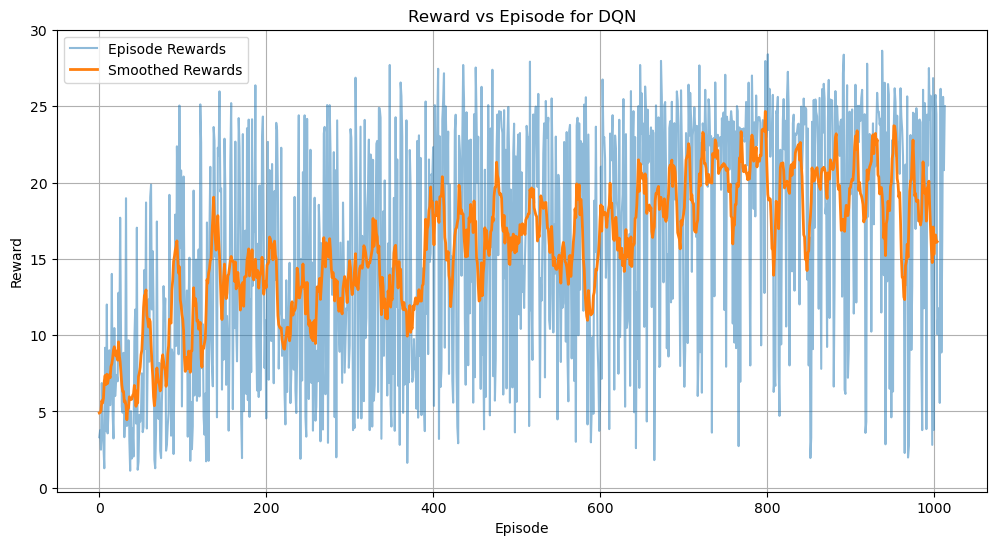

/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Conside

Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4


Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4
Mean Reward: 19.453946724534035, Std Reward: 7.252007843886069
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4


In [85]:
# To train and evaluate DQN
dqn_model, dqn_env = train_model('DQN')
dqn_reward_mean, dqn_reward_std = evaluate_and_record(dqn_model, dqn_env)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./highway_ppo/PPO_4


/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | 8.08     |
| time/              |          |
|    fps             | 58       |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 768      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 8.7         |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 1536        |
| train/                  |             |
|    approx_kl            | 0.011413711 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00227     |
|    learning_rate        | 0.

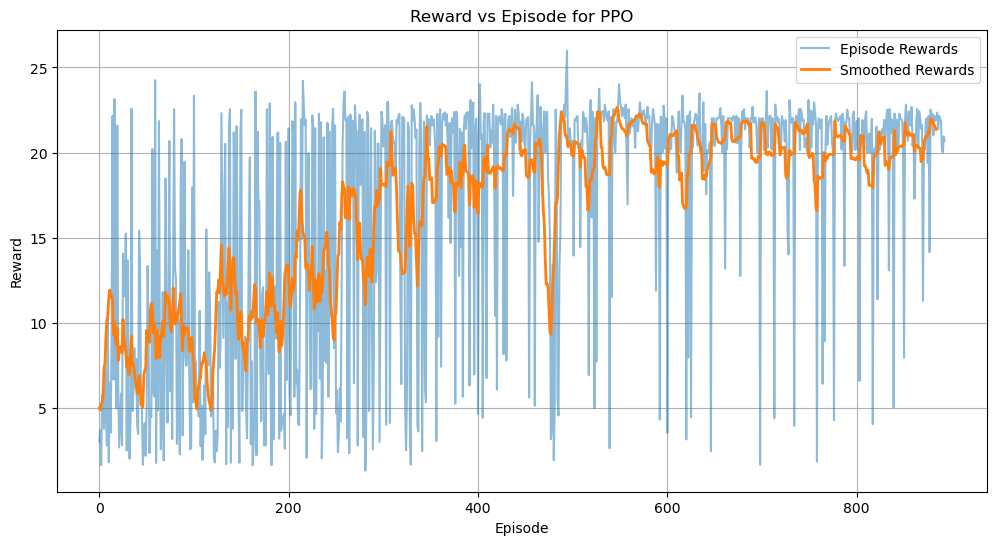

/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Conside

Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-0.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-1.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-2.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-3.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-4.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-5.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-6.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-7.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-8.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-9.mp4
Mean Reward: 21.427481496334075, Std Reward: 0.8000000000000214
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_PPO_baseline_model/rl-video-episode-10.mp4


In [86]:
# To train and evaluate PPO
ppo_model, ppo_env = train_model('PPO')
ppo_reward_mean, ppo_reward_std = evaluate_and_record(ppo_model, ppo_env)

In [92]:
def train_env():
    env = gym.make('highway-fast-v0', render_mode='rgb_array')
    env.configure({
        "observation": {
            "type": "GrayscaleObservation",
            "observation_shape": (128, 64),
            "stack_size": 4,
            "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
            "scaling": 1.75,
        },
    })
    env.reset()
    return env

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to highway_cnn/DQN_7


/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.5     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 63       |
|    time_elapsed     | 1        |
|    total_timesteps  | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 12.3     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 63       |
|    time_elapsed     | 2        |
|    total_timesteps  | 131      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes       

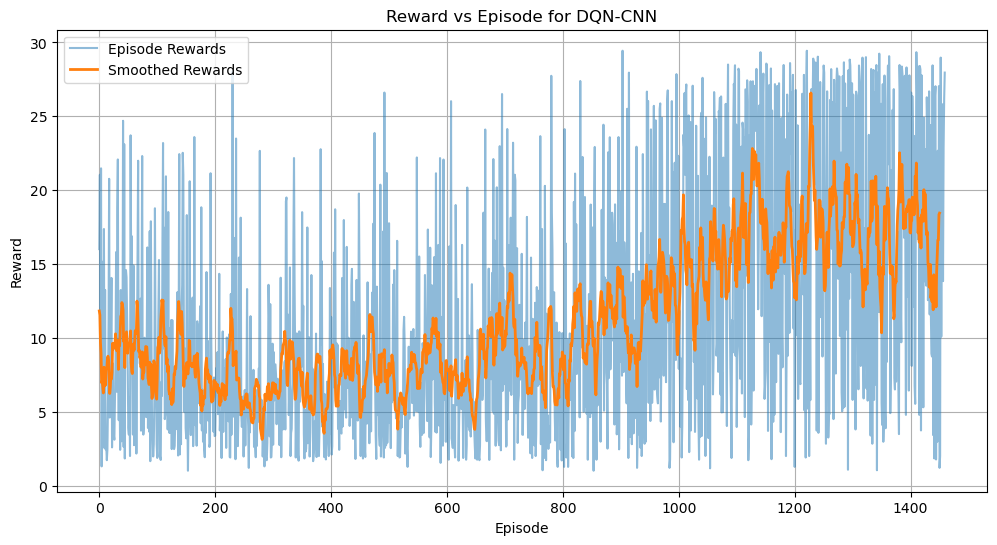

/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Conside

Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4


Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4


Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4
Mean Reward: 160.91910727620126, Std Reward: 80.25247518664862
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4


In [90]:
# Training the model
training_env = train_env()
model = DQN(
    "CnnPolicy",
    training_env,
    learning_rate=5e-4,
    buffer_size=15000,
    learning_starts=200,
    batch_size=32,
    gamma=0.8,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=50,
    exploration_fraction=0.7,
    verbose=1,
    tensorboard_log="highway_cnn/"
)

callback = RewardLoggingCallback()
model.learn(total_timesteps=int(20000), callback=callback)
model.save("highway_cnn/model")

smoothed_rewards = callback.get_smoothed_rewards()

# Plotting the reward vs episode graph
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label='Episode Rewards', alpha=0.5)  # alpha set for transparency
plt.plot(smoothed_rewards, label='Smoothed Rewards', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Reward vs Episode for DQN-CNN')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
# Load model and record video
model = DQN.load("highway_cnn/model")
env = train_env()

dqn_cnn_reward_mean, dqn_cnn_reward_std = evaluate_and_record(model, env)

/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Conside

Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-0.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-1.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-2.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-3.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-4.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-5.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-6.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-7.mp4
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-8.mp4


Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-9.mp4
Mean Reward: 16.933548918366434, Std Reward: 9.078481045065297
Moviepy - Building video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/jonathanhu/autonomous_driving_sim/highway_DQN_baseline_model/rl-video-episode-10.mp4
